## 1. Setup & Configuration

In [1]:
import yaml
import os
import sys
import json
import tempfile

# Windows compatibility
if sys.platform == "win32":
    import socketserver
    if not hasattr(socketserver, 'UnixStreamServer'):
        socketserver.UnixStreamServer = socketserver.TCPServer

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum as spark_sum, count, countDistinct, desc, lit, avg, row_number,
    radians, sin, cos, sqrt, atan2, max as spark_max, min as spark_min,
    first, collect_list, struct
)
from pyspark.sql.types import (
    StructType, StructField, StringType, FloatType, DoubleType, IntegerType, DateType
)
from pyspark.sql.window import Window

# Load configuration
with open("../../config/config.yml") as f:
    config = yaml.safe_load(f)

# Buffer pour l'approche directe (plus large car plus de points)
BUFFER_M = 100  # 100m buffer

silver_dir = config["paths"]["silver_dir"]
gold_dir = config["paths"]["gold_dir"]

print(f"✓ Buffer distance: {BUFFER_M}m (direct measures approach)")
print(f"✓ Silver data: {silver_dir}")
print(f"✓ Gold output: {gold_dir}")

✓ Buffer distance: 100m (direct measures approach)
✓ Silver data: data/silver
✓ Gold output: data/gold


In [2]:
# Initialize Spark session
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
local_temp = tempfile.gettempdir()

spark = SparkSession.builder \
    .appName("Module2_SpatialUsage_DirectMeasures") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.ui.enabled", "false") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.local.dir", local_temp) \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"✓ Spark version: {spark.version}")

✓ Spark version: 3.5.3


## 2. Load Silver Data

In [3]:
silver_path = f"../../{silver_dir}"

# Charger aménagements avec coordonnées complètes
df_amenagements = spark.read.parquet(f"{silver_path}/silver_amenagements_with_coordinates")

# Charger les mesures (union auto + manuel)
df_measures = spark.read.parquet(f"{silver_path}/silver_measures_union2")

print("✓ Loaded Silver Parquet files:")
print(f"  - silver_amenagements_with_coordinates: {df_amenagements.count()} rows")
print(f"  - silver_measures_union2: {df_measures.count()} rows")

✓ Loaded Silver Parquet files:
  - silver_amenagements_with_coordinates: 4592 rows
  - silver_measures_union2: 485651 rows


In [4]:
# Vérifier la structure des mesures
print("=== Structure silver_measures_union2 ===")
df_measures.printSchema()

print("\n=== Aperçu des mesures ===")
df_measures.show(10)

print("\n=== Types de points ===")
df_measures.groupBy("point_type").count().show()

=== Structure silver_measures_union2 ===
root
 |-- point_id: string (nullable = true)
 |-- point_type: string (nullable = true)
 |-- flux: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- direction: string (nullable = true)
 |-- vehicule_type: string (nullable = true)
 |-- date: date (nullable = true)


=== Aperçu des mesures ===
+---------+----------+----+------------------+------------------+---------+-------------+----------+
| point_id|point_type|flux|               lat|               lon|direction|vehicule_type|      date|
+---------+----------+----+------------------+------------------+---------+-------------+----------+
|100031128|      auto| 726|          45.72373|          4.893222|     NULL|         NULL|2023-02-06|
|100030258|      auto|3763|45.743805467619744|4.8410793877663005|     NULL|         NULL|2023-02-06|
|100031124|      auto| 793|          45.75127|           4.82288|     NULL|         NULL|2023-02-06|
|100047690

In [5]:
# Extraire les points de mesure UNIQUES (point_id → lat, lon)
# Vérifier si un point_id a toujours les mêmes coordonnées

df_points_unique = df_measures.select(
    "point_id", "point_type", "lat", "lon"
).distinct()

# Compter combien de coordonnées par point_id
coords_per_point = df_points_unique.groupBy("point_id").count()
multi_coords = coords_per_point.filter(col("count") > 1)

print(f"✓ Points de mesure uniques: {df_points_unique.count()}")
print(f"✓ Points avec coordonnées multiples: {multi_coords.count()}")

if multi_coords.count() > 0:
    print("\n⚠️  Certains points ont plusieurs coordonnées:")
    multi_coords.show(5)

✓ Points de mesure uniques: 206
✓ Points avec coordonnées multiples: 0


In [6]:
# Si des points ont plusieurs coordonnées, on prend la première (ou la plus fréquente)
# Pour simplifier, on prend les coordonnées les plus fréquentes par point_id

window_spec = Window.partitionBy("point_id").orderBy(col("count").desc())

# Compter les occurrences de chaque combinaison (point_id, lat, lon)
df_point_coords_count = df_measures.groupBy("point_id", "point_type", "lat", "lon").count()

# Garder la combinaison la plus fréquente pour chaque point_id
df_points = df_point_coords_count.withColumn(
    "rank", row_number().over(window_spec)
).filter(col("rank") == 1).select(
    "point_id", "point_type", "lat", "lon"
)

print(f"✓ Points de mesure finaux: {df_points.count()}")
print(f"\n=== Répartition par type ===")
df_points.groupBy("point_type").count().show()

df_points.show(10)

✓ Points de mesure finaux: 206

=== Répartition par type ===
+----------+-----+
|point_type|count|
+----------+-----+
|      auto|  193|
|    manual|   13|
+----------+-----+

+---------+----------+------------------+------------------+
| point_id|point_type|               lat|               lon|
+---------+----------+------------------+------------------+
|     NULL|    manual|        45.8010069|         4.8536232|
|100013842|      auto|         45.732002|          4.821243|
|100017787|      auto|          45.77062|           4.93573|
|100017788|      auto|45.795592605137955| 4.990856051445008|
|100017789|      auto| 45.76698223122747| 4.918236583471299|
|100017791|      auto|          45.77492|            4.9542|
|100017792|      auto| 45.77073817594027|4.9357686189513625|
|100017793|      auto| 45.77486440927123| 4.954341799020768|
|100024515|      auto|          45.78389|           4.89176|
|100026724|      auto| 45.72246529189946|  4.88743543624878|
+---------+----------+---------

## 3. Calcul des distances: Points de mesure ↔ Tracés des aménagements

**Approche:**
1. Pour chaque point de mesure, calculer la distance minimale à chaque aménagement
2. Utiliser le tracé complet (pas le centroïde)
3. Filtrer par buffer (100m)
4. Un point peut être associé à plusieurs aménagements (si proche de plusieurs)

In [7]:
# Convertir en Pandas pour le traitement des coordonnées
import pandas as pd
import numpy as np

print("Converting to Pandas for coordinate processing...")
pdf_amenagements = df_amenagements.toPandas()
pdf_points = df_points.toPandas()

print(f"✓ Amenagements: {len(pdf_amenagements)} rows")
print(f"✓ Points de mesure: {len(pdf_points)} rows")

Converting to Pandas for coordinate processing...
✓ Amenagements: 4592 rows
✓ Points de mesure: 206 rows


In [8]:
# Fonction Haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcule la distance en mètres entre deux points GPS.
    """
    R = 6371000  # Rayon de la Terre en mètres
    
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

print("✓ Haversine function ready")

✓ Haversine function ready


In [9]:
# Parser les coordonnées des aménagements et calculer les bounding boxes
def parse_coordinates_and_bbox(coords_str):
    """
    Parse le JSON des coordonnées et retourne:
    - Liste des points [(lat, lon), ...]
    - Bounding box (min_lat, max_lat, min_lon, max_lon)
    """
    if pd.isna(coords_str):
        return None, None
    
    try:
        coords = json.loads(coords_str)
        all_points = []
        
        for segment in coords:
            for point in segment:
                lon, lat = point[0], point[1]  # Format GeoJSON: [lon, lat]
                all_points.append((lat, lon))
        
        if not all_points:
            return None, None
        
        lats = [p[0] for p in all_points]
        lons = [p[1] for p in all_points]
        bbox = (min(lats), max(lats), min(lons), max(lons))
        
        return all_points, bbox
        
    except Exception as e:
        return None, None

print("Parsing coordinates and computing bounding boxes...")
pdf_amenagements['parsed'] = pdf_amenagements['coordiantes'].apply(parse_coordinates_and_bbox)
pdf_amenagements['all_points'] = pdf_amenagements['parsed'].apply(lambda x: x[0] if x else None)
pdf_amenagements['bbox'] = pdf_amenagements['parsed'].apply(lambda x: x[1] if x else None)
pdf_amenagements.drop('parsed', axis=1, inplace=True)

n_with_coords = pdf_amenagements['all_points'].notna().sum()
print(f"✓ {n_with_coords} aménagements avec coordonnées parsées")

Parsing coordinates and computing bounding boxes...
✓ 4592 aménagements avec coordonnées parsées


In [10]:
# Fonction pour calculer la distance minimale au tracé
def min_distance_to_path(point_lat, point_lon, path_points):
    """
    Calcule la distance minimale entre un point et une liste de points (tracé).
    """
    if path_points is None or len(path_points) == 0:
        return float('inf')
    
    min_dist = float('inf')
    for path_lat, path_lon in path_points:
        dist = haversine_distance(point_lat, point_lon, path_lat, path_lon)
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

print("✓ Distance calculation function ready")

✓ Distance calculation function ready


In [11]:
# OPTIMISATION: Pré-filtrage par bounding box
MARGIN_DEG = BUFFER_M / 111000 * 1.5  # Marge de sécurité

print(f"Buffer: {BUFFER_M}m")
print(f"Bounding box margin: {MARGIN_DEG:.6f} degrees (~{BUFFER_M*1.5:.0f}m)")
print(f"\nCalculating point-amenagement pairs...")
print(f"Total comparisons to check: {len(pdf_points)} x {n_with_coords} = {len(pdf_points) * n_with_coords:,}")

# Calculer toutes les paires (point, amenagement) candidates
candidate_pairs = []
n_total = 0
n_bbox_filtered = 0

amenagements_with_coords = pdf_amenagements[pdf_amenagements['bbox'].notna()]

for idx, point in pdf_points.iterrows():
    point_id = point['point_id']
    point_type = point['point_type']
    point_lat = point['lat']
    point_lon = point['lon']
    
    for _, amen in amenagements_with_coords.iterrows():
        n_total += 1
        amen_id = amen['amenagement_id']
        min_lat, max_lat, min_lon, max_lon = amen['bbox']
        
        # Pré-filtre par bounding box
        if (min_lat - MARGIN_DEG <= point_lat <= max_lat + MARGIN_DEG and
            min_lon - MARGIN_DEG <= point_lon <= max_lon + MARGIN_DEG):
            
            # Calculer distance exacte
            dist = min_distance_to_path(point_lat, point_lon, amen['all_points'])
            
            if dist <= BUFFER_M:
                candidate_pairs.append({
                    'point_id': point_id,
                    'point_type': point_type,
                    'amenagement_id': amen_id,
                    'distance_m': dist
                })
        else:
            n_bbox_filtered += 1
    
    # Progress indicator
    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1}/{len(pdf_points)} points...", end="\r")

print(f"\n\n✓ Total comparisons: {n_total:,}")
print(f"✓ Filtered by bounding box: {n_bbox_filtered:,} ({n_bbox_filtered/n_total*100:.1f}%)")
print(f"✓ Candidate pairs within {BUFFER_M}m: {len(candidate_pairs):,}")

Buffer: 100m
Bounding box margin: 0.001351 degrees (~150m)

Calculating point-amenagement pairs...
Total comparisons to check: 206 x 4592 = 945,952
  Processed 200/206 points...

✓ Total comparisons: 945,952
✓ Filtered by bounding box: 944,316 (99.8%)
✓ Candidate pairs within 100m: 1,054


In [12]:
# Créer DataFrame des liens point-amenagement
df_links = pd.DataFrame(candidate_pairs)

if len(df_links) == 0:
    print("❌ ERREUR: Aucune paire trouvée! Vérifier les données ou augmenter le buffer.")
else:
    print(f"✓ Created {len(df_links)} point-amenagement links")
    
    # Stats
    n_points_linked = df_links['point_id'].nunique()
    n_amenagements_linked = df_links['amenagement_id'].nunique()
    
    print(f"\n=== COUVERTURE ===")
    print(f"  Points de mesure associés: {n_points_linked} / {len(pdf_points)} ({n_points_linked/len(pdf_points)*100:.1f}%)")
    print(f"  Aménagements couverts: {n_amenagements_linked} / {len(pdf_amenagements)} ({n_amenagements_linked/len(pdf_amenagements)*100:.1f}%)")
    
    print(f"\n=== DISTANCES ===")
    print(f"  Distance moyenne: {df_links['distance_m'].mean():.1f}m")
    print(f"  Distance médiane: {df_links['distance_m'].median():.1f}m")
    print(f"  Distance max: {df_links['distance_m'].max():.1f}m")
    
    print(f"\n=== PAR TYPE DE POINT ===")
    print(df_links.groupby('point_type').agg({
        'point_id': 'nunique',
        'amenagement_id': 'nunique'
    }).rename(columns={'point_id': 'n_points', 'amenagement_id': 'n_amenagements'}))
    
    df_links.head(10)

✓ Created 1054 point-amenagement links

=== COUVERTURE ===
  Points de mesure associés: 192 / 206 (93.2%)
  Aménagements couverts: 475 / 4592 (10.3%)

=== DISTANCES ===
  Distance moyenne: 44.9m
  Distance médiane: 39.4m
  Distance max: 100.0m

=== PAR TYPE DE POINT ===
            n_points  n_amenagements
point_type                          
auto             184             460
manual             8              27


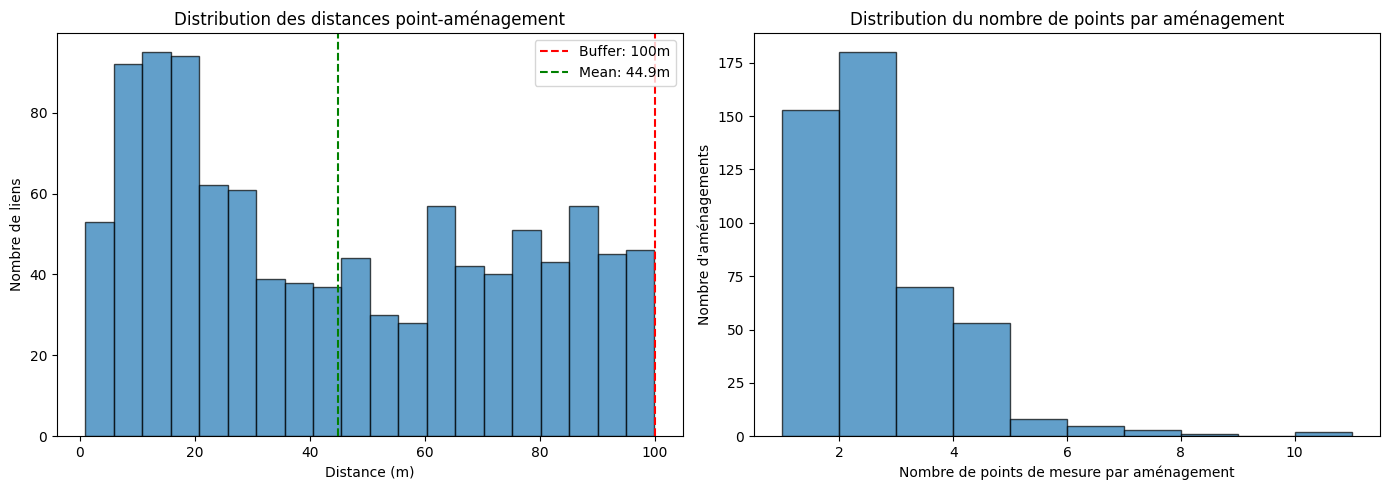

In [13]:
# Distribution des distances
import matplotlib.pyplot as plt

if len(df_links) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogramme des distances
    axes[0].hist(df_links['distance_m'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(BUFFER_M, color='red', linestyle='--', label=f'Buffer: {BUFFER_M}m')
    axes[0].axvline(df_links['distance_m'].mean(), color='green', linestyle='--', 
                    label=f'Mean: {df_links["distance_m"].mean():.1f}m')
    axes[0].set_xlabel('Distance (m)')
    axes[0].set_ylabel('Nombre de liens')
    axes[0].set_title('Distribution des distances point-aménagement')
    axes[0].legend()
    
    # Nombre de liens par aménagement
    links_per_amen = df_links.groupby('amenagement_id').size()
    axes[1].hist(links_per_amen, bins=range(1, links_per_amen.max()+2), edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Nombre de points de mesure par aménagement')
    axes[1].set_ylabel('Nombre d\'aménagements')
    axes[1].set_title('Distribution du nombre de points par aménagement')
    
    plt.tight_layout()
    plt.show()

## 4. Créer les tables Gold avec moyenne pondérée

**Formule de pondération:**
- Poids = 1 / (distance + 1)  (évite division par 0)
- flux_pondéré = Σ(flux × poids) / Σ(poids)

In [14]:
# Ajouter les poids basés sur la distance inverse
df_links['weight'] = 1 / (df_links['distance_m'] + 1)  # +1 pour éviter division par 0

print("=== Poids calculés ===")
print(f"  Poids min: {df_links['weight'].min():.4f} (distance max)")
print(f"  Poids max: {df_links['weight'].max():.4f} (distance min)")
print(f"  Poids moyen: {df_links['weight'].mean():.4f}")

df_links.head()

=== Poids calculés ===
  Poids min: 0.0099 (distance max)
  Poids max: 0.5117 (distance min)
  Poids moyen: 0.0459


,point_id,point_type,amenagement_id,distance_m,weight
0,None,manual,6900,24.500966,0.039214
1,None,manual,538,9.092429,0.099084
2,100013842,auto,4032,76.737630,0.012864
3,100013842,auto,4195,36.311654,0.026801
4,100013842,auto,2136,91.363766,0.010827


In [15]:
# Créer gold_link_amenagement_point (remplace gold_link_amenagement_channel)
# Garder tous les liens (un point peut être associé à plusieurs aménagements)

gold_link_pdf = df_links[['amenagement_id', 'point_id', 'point_type', 'distance_m', 'weight']].copy()

print(f"✓ gold_link_amenagement_point: {len(gold_link_pdf)} rows")
print(f"✓ Aménagements uniques: {gold_link_pdf['amenagement_id'].nunique()}")
print(f"✓ Points uniques: {gold_link_pdf['point_id'].nunique()}")

gold_link_pdf.head(10)

✓ gold_link_amenagement_point: 1054 rows
✓ Aménagements uniques: 475
✓ Points uniques: 192


,amenagement_id,point_id,point_type,distance_m,weight
0,6900,None,manual,24.500966,0.039214
1,538,None,manual,9.092429,0.099084
2,4032,100013842,auto,76.737630,0.012864
3,4195,100013842,auto,36.311654,0.026801
4,2136,100013842,auto,91.363766,0.010827
5,726,100013842,auto,91.087569,0.010859
6,4196,100013842,auto,19.676433,0.048364
7,2159,100013842,auto,7.744474,0.114358
8,4031,100013842,auto,5.177127,0.161888
9,843,100017787,auto,9.218194,0.097865


In [16]:
# Sauvegarder gold_link avec Pandas (évite le crash Spark sur Windows)
gold_path = f"../../{gold_dir}"
os.makedirs(gold_path, exist_ok=True)

# Convertir types
gold_link_pdf['amenagement_id'] = gold_link_pdf['amenagement_id'].astype(str)
gold_link_pdf['point_id'] = gold_link_pdf['point_id'].astype(str)
gold_link_pdf['point_type'] = gold_link_pdf['point_type'].astype(str)
gold_link_pdf['distance_m'] = gold_link_pdf['distance_m'].astype(float)
gold_link_pdf['weight'] = gold_link_pdf['weight'].astype(float)

# Sauvegarder
link_path = f"{gold_path}/gold_link_amenagement_point"
os.makedirs(link_path, exist_ok=True)
gold_link_pdf.to_parquet(f"{link_path}/part-0.parquet", index=False)

print(f"✓ Saved gold_link_amenagement_point to {link_path}")

✓ Saved gold_link_amenagement_point to ../../data/gold/gold_link_amenagement_point


In [17]:
# Charger les mesures pour calculer les flux
pdf_measures = df_measures.toPandas()

print(f"✓ Mesures chargées: {len(pdf_measures)} rows")
print(f"✓ Période: {pdf_measures['date'].min()} → {pdf_measures['date'].max()}")

✓ Mesures chargées: 485651 rows
✓ Période: 2014-01-01 → 2025-12-01


In [18]:
# Joindre les mesures avec les liens (point_id)
df_measures_linked = pdf_measures.merge(
    gold_link_pdf[['amenagement_id', 'point_id', 'weight']],
    on='point_id',
    how='inner'
)

print(f"✓ Mesures liées aux aménagements: {len(df_measures_linked)} rows")
print(f"✓ Aménagements avec mesures: {df_measures_linked['amenagement_id'].nunique()}")

df_measures_linked.head()

✓ Mesures liées aux aménagements: 2763933 rows
✓ Aménagements avec mesures: 475


,point_id,point_type,flux,lat,lon,direction,vehicule_type,date,amenagement_id,weight
0,100031128,auto,726,45.723730,4.893222,None,None,2023-02-06,474,0.028967
1,100030258,auto,3763,45.743805,4.841079,None,None,2023-02-06,6266,0.010736
2,100030258,auto,3763,45.743805,4.841079,None,None,2023-02-06,4958,0.105861
3,100030258,auto,3763,45.743805,4.841079,None,None,2023-02-06,299,0.105861
4,100030258,auto,3763,45.743805,4.841079,None,None,2023-02-06,6265,0.010736


In [19]:
# Calculer le flux pondéré par aménagement et par jour
# Formule: flux_estime = Σ(flux × weight) / Σ(weight)

df_measures_linked['flux_weighted'] = df_measures_linked['flux'] * df_measures_linked['weight']

# Agréger par amenagement_id et date
gold_flow_daily = df_measures_linked.groupby(['amenagement_id', 'date']).agg({
    'flux_weighted': 'sum',
    'weight': 'sum',
    'point_id': 'nunique'
}).reset_index()

# Calculer le flux estimé (moyenne pondérée)
gold_flow_daily['flux_estime'] = gold_flow_daily['flux_weighted'] / gold_flow_daily['weight']
gold_flow_daily = gold_flow_daily.rename(columns={'point_id': 'n_points'})

# Garder les colonnes finales
gold_flow_daily = gold_flow_daily[['amenagement_id', 'date', 'flux_estime', 'n_points']]

# Arrondir le flux
gold_flow_daily['flux_estime'] = gold_flow_daily['flux_estime'].round(2)

print(f"✓ gold_flow_amenagement_daily: {len(gold_flow_daily)} rows")
print(f"✓ Aménagements uniques: {gold_flow_daily['amenagement_id'].nunique()}")
print(f"✓ Période: {gold_flow_daily['date'].min()} → {gold_flow_daily['date'].max()}")

gold_flow_daily.head(20)

✓ gold_flow_amenagement_daily: 1323674 rows
✓ Aménagements uniques: 475
✓ Période: 2014-01-01 → 2025-12-01


,amenagement_id,date,flux_estime,n_points
0,100,2014-01-01,101.0,2
1,100,2014-01-02,209.0,2
2,100,2014-01-03,140.0,2
3,100,2014-01-04,90.0,2
4,100,2014-01-05,101.0,2
5,100,2014-01-06,367.0,2
6,100,2014-01-07,303.0,2
7,100,2014-01-08,264.0,2
8,100,2014-01-09,324.0,2
9,100,2014-01-10,345.0,2


In [23]:
# Statistiques détaillées
print("=== STATISTIQUES FLUX JOURNALIERS ===")
print(f"\nFlux estimé:")
print(f"  Min: {gold_flow_daily['flux_estime'].min():.1f}")
print(f"  Max: {gold_flow_daily['flux_estime'].max():.1f}")
print(f"  Moyenne: {gold_flow_daily['flux_estime'].mean():.1f}")
print(f"  Médiane: {gold_flow_daily['flux_estime'].median():.1f}")

print(f"\nNombre de points par jour/aménagement:")
print(f"  Min: {gold_flow_daily['n_points'].min()}")
print(f"  Max: {gold_flow_daily['n_points'].max()}")
print(f"  Moyenne: {gold_flow_daily['n_points'].mean():.1f}")

=== STATISTIQUES FLUX JOURNALIERS ===

Flux estimé:
  Min: 0.0
  Max: 36024.0
  Moyenne: 1544.5
  Médiane: 1021.9

Nombre de points par jour/aménagement:
  Min: 1
  Max: 9
  Moyenne: 2.1


## 5. Data Quality Checks

In [24]:
# Check 1: Nombre d'aménagements avec données
amen_with_data = gold_flow_daily['amenagement_id'].nunique()
total_amen = len(pdf_amenagements)

print(f"=== RÉSULTATS DIRECT MEASURES APPROACH ===")
print(f"✓ Aménagements avec flux: {amen_with_data} / {total_amen} ({amen_with_data/total_amen*100:.1f}%)")

# Check 2: Pas de flux négatifs
negative_flux = (gold_flow_daily['flux_estime'] < 0).sum()
assert negative_flux == 0, "FAILED: Found negative flux values"
print(f"✓ No negative flux values")

# Check 3: n_points >= 1
zero_points = (gold_flow_daily['n_points'] < 1).sum()
assert zero_points == 0, "FAILED: Found days with 0 points"
print(f"✓ All days have at least 1 measurement point")

# Check 4: Pas de duplicates
duplicates = gold_flow_daily.groupby(['amenagement_id', 'date']).size()
n_duplicates = (duplicates > 1).sum()
assert n_duplicates == 0, f"FAILED: {n_duplicates} duplicates found"
print(f"✓ No duplicate (amenagement_id, date) entries")

print(f"\n🎉 All quality checks passed!")

=== RÉSULTATS DIRECT MEASURES APPROACH ===
✓ Aménagements avec flux: 475 / 4592 (10.3%)
✓ No negative flux values
✓ All days have at least 1 measurement point
✓ No duplicate (amenagement_id, date) entries

🎉 All quality checks passed!


In [25]:
# Summary par aménagement
summary = gold_flow_daily.groupby('amenagement_id').agg({
    'date': 'count',
    'flux_estime': ['sum', 'mean'],
    'n_points': 'max'
}).reset_index()

summary.columns = ['amenagement_id', 'total_days', 'total_flux', 'avg_daily_flux', 'max_points']
summary = summary.sort_values('avg_daily_flux', ascending=False)

print("=== Top 20 aménagements par flux moyen journalier ===")
summary.head(20)

=== Top 20 aménagements par flux moyen journalier ===


,amenagement_id,total_days,total_flux,avg_daily_flux,max_points
235,4112,4266,27647824.41,6480.971498,5
194,3639,4286,26026957.82,6072.551988,7
147,2846,4266,25011314.70,5862.942968,5
383,6618,4266,24682270.22,5785.811116,4
142,2827,4266,24682270.22,5785.811116,4
439,7514,4266,24458843.77,5733.437358,2
384,6620,4266,23700430.59,5555.656491,4
148,2847,4262,22661262.63,5317.048951,3
240,417,4286,21474461.64,5010.373691,7
146,2845,4224,19794878.09,4686.287427,3


## 6. Save Outputs (Parquet)

In [26]:
# Convertir types pour gold_flow_daily
gold_flow_daily['amenagement_id'] = gold_flow_daily['amenagement_id'].astype(str)
gold_flow_daily['flux_estime'] = gold_flow_daily['flux_estime'].astype(float)
gold_flow_daily['n_points'] = gold_flow_daily['n_points'].astype(int)

# Renommer n_points en n_channels pour compatibilité avec le format existant
gold_flow_daily_final = gold_flow_daily.rename(columns={'n_points': 'n_channels'})

# Sauvegarder
flow_path = f"{gold_path}/gold_flow_amenagement_daily"
os.makedirs(flow_path, exist_ok=True)
gold_flow_daily_final.to_parquet(f"{flow_path}/part-0.parquet", index=False)

print(f"✓ Saved gold_flow_amenagement_daily to {flow_path}")
print(f"\n✅ All Gold outputs saved!")

✓ Saved gold_flow_amenagement_daily to ../../data/gold/gold_flow_amenagement_daily

✅ All Gold outputs saved!


In [27]:
# Vérifier les fichiers sauvegardés
print("=== Vérification des fichiers Gold Parquet ===")

# gold_link_amenagement_point
df_link_check = spark.read.parquet(f"{gold_path}/gold_link_amenagement_point")
print(f"\ngold_link_amenagement_point: {df_link_check.count()} rows")
df_link_check.printSchema()
df_link_check.show(5)

# gold_flow_amenagement_daily
df_flow_check = spark.read.parquet(f"{gold_path}/gold_flow_amenagement_daily")
print(f"\ngold_flow_amenagement_daily: {df_flow_check.count()} rows")
df_flow_check.printSchema()
df_flow_check.show(5)

=== Vérification des fichiers Gold Parquet ===

gold_link_amenagement_point: 1054 rows
root
 |-- amenagement_id: string (nullable = true)
 |-- point_id: string (nullable = true)
 |-- point_type: string (nullable = true)
 |-- distance_m: double (nullable = true)
 |-- weight: double (nullable = true)

+--------------+---------+----------+------------------+--------------------+
|amenagement_id| point_id|point_type|        distance_m|              weight|
+--------------+---------+----------+------------------+--------------------+
|          6900|     None|    manual|24.500966257840137| 0.03921420035182217|
|           538|     None|    manual| 9.092429094260481|   0.099084173954583|
|          4032|100013842|      auto| 76.73763025216392|0.012863782916410212|
|          4195|100013842|      auto|36.311653585700405|0.026801277989546072|
|          2136|100013842|      auto| 91.36376556960457|0.010826756508172117|
+--------------+---------+----------+------------------+-------------------

## 7. Comparaison avec les approches précédentes

In [28]:
print("="*60)
print("📊 COMPARAISON DES APPROCHES")
print("="*60)

print(f"\n🆕 DIRECT MEASURES APPROACH (buffer={BUFFER_M}m):")
print(f"   • Source: silver_measures_union2 (auto + manuel)")
print(f"   • Points de mesure utilisés: {n_points_linked}")
print(f"   • Aménagements avec données: {amen_with_data} / {total_amen} ({amen_with_data/total_amen*100:.1f}%)")
print(f"   • Agrégation: Moyenne pondérée par distance inverse")

print(f"\n📌 Avantages:")
print(f"   • Utilise TOUS les points de mesure (auto + manuel)")
print(f"   • Plus de couverture géographique")
print(f"   • Pondération évite de gonfler artificiellement les flux")
print(f"   • Distance au tracé RÉEL (pas au centroïde)")

print(f"\n✅ Format Gold compatible avec le pipeline existant")

📊 COMPARAISON DES APPROCHES

🆕 DIRECT MEASURES APPROACH (buffer=100m):
   • Source: silver_measures_union2 (auto + manuel)
   • Points de mesure utilisés: 192
   • Aménagements avec données: 475 / 4592 (10.3%)
   • Agrégation: Moyenne pondérée par distance inverse

📌 Avantages:
   • Utilise TOUS les points de mesure (auto + manuel)
   • Plus de couverture géographique
   • Pondération évite de gonfler artificiellement les flux
   • Distance au tracé RÉEL (pas au centroïde)

✅ Format Gold compatible avec le pipeline existant


## 8. Export CSV pour analyse (optionnel)

In [29]:
# Exporter un résumé en CSV pour analyse facile
summary_export = summary.copy()
summary_export.to_csv(f"{gold_path}/gold_summary_amenagements_direct.csv", index=False)
print(f"✓ Exported summary to {gold_path}/gold_summary_amenagements_direct.csv")

# Exporter aussi le détail des liens
gold_link_pdf.to_csv(f"{gold_path}/gold_link_amenagement_point.csv", index=False)
print(f"✓ Exported links to {gold_path}/gold_link_amenagement_point.csv")

✓ Exported summary to ../../data/gold/gold_summary_amenagements_direct.csv
✓ Exported links to ../../data/gold/gold_link_amenagement_point.csv


## 9. Cleanup

In [30]:
spark.stop()
print("✓ Spark session stopped")

✓ Spark session stopped
